In [64]:
from pandas import DataFrame, read_csv, to_numeric, Series
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from bigml.api import BigML
import kaggle
from pprint import pprint

%matplotlib inline

In [65]:
ensemble_prediction_file = 'gmsc-valid-pred-v1.3.csv'
deepnet_prediction_file = 'gmsc-valid-pred-v1.3-deep.csv'

In [66]:
deepnet_prediction=read_csv(deepnet_prediction_file, index_col='Id')
ensemble_prediction=read_csv(ensemble_prediction_file, index_col='Id')

In [67]:
deepnet_score = roc_auc_score(deepnet_prediction['SeriousDlqin2yrs'].values,deepnet_prediction['1 probability'].values)
ensemble_score = roc_auc_score(ensemble_prediction['SeriousDlqin2yrs'].values,ensemble_prediction['1 probability'].values)
print(f"Deep Net auc: {deepnet_score}")
print(f"Ensemble auc: {ensemble_score}")

Deep Net auc: 0.8510255923768169
Ensemble auc: 0.8555263502630377


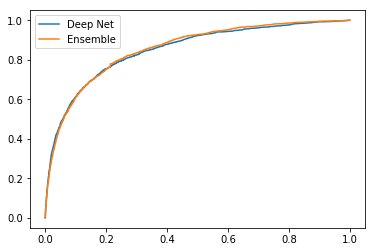

In [68]:
deep_fpr, deep_tpr, deep_thresholds = roc_curve(deepnet_prediction['SeriousDlqin2yrs'], deepnet_prediction['1 probability'])
ens_fpr, ens_tpr, ens_thresholds = roc_curve(ensemble_prediction['SeriousDlqin2yrs'], ensemble_prediction['1 probability'])

plt.plot(deep_fpr, deep_tpr, label="Deep Net")
plt.plot(ens_fpr, ens_tpr, label="Ensemble")
#plt.plot( 'x', 'y3', data=df, marker='', color='olive', linewidth=2, linestyle='dashed', label="toto")
plt.legend()
plt.show()

In [69]:
TP_cost = 0
FN_cost = -2500
FP_cost = -500
TN_cost = 500

In [70]:
ensemble_is_positive = (ensemble_prediction['SeriousDlqin2yrs'] == 1)
ensemble_nb_positive = len(ensemble_prediction.loc[ensemble_is_positive])
ensemble_nb_negative = len(ensemble_prediction.loc[~ensemble_is_positive])

In [71]:
deepnet_is_positive = (deepnet_prediction['SeriousDlqin2yrs'] == 1)
deepnet_nb_positive = len(deepnet_prediction.loc[deepnet_is_positive])
deepnet_nb_negative = len(deepnet_prediction.loc[~deepnet_is_positive])

In [72]:
ensemble_cost = ensemble_prediction[['SeriousDlqin2yrs','1 probability']]
ensemble_cost = ensemble_cost.sort_values(by='1 probability',ascending=False)

ensemble_cost['nb_TP'] = ensemble_cost['SeriousDlqin2yrs'].cumsum()
ensemble_cost['nb_TN'] = ensemble_nb_negative - (1-ensemble_cost['SeriousDlqin2yrs']).cumsum() # inverted cumulative sum of negative cases
ensemble_cost['nb_FP'] = ensemble_nb_negative - ensemble_cost['nb_TN']
ensemble_cost['nb_FN'] = ensemble_nb_positive - ensemble_cost['nb_TP']

ensemble_cost['cost'] = ensemble_cost['nb_TP']*TP_cost+ensemble_cost['nb_TN']*TN_cost+ensemble_cost['nb_FP']*FP_cost+ensemble_cost['nb_FN']*FN_cost

In [73]:
deepnet_cost = deepnet_prediction[['SeriousDlqin2yrs','1 probability']]
deepnet_cost = deepnet_cost.sort_values(by='1 probability',ascending=False)

deepnet_cost['nb_TP'] = deepnet_cost['SeriousDlqin2yrs'].cumsum()
deepnet_cost['nb_TN'] = deepnet_nb_negative - (1-deepnet_cost['SeriousDlqin2yrs']).cumsum() # inverted cumulative sum of negative cases
deepnet_cost['nb_FP'] = deepnet_nb_negative - deepnet_cost['nb_TN']
deepnet_cost['nb_FN'] = deepnet_nb_positive - deepnet_cost['nb_TP']

deepnet_cost['cost'] = deepnet_cost['nb_TP']*TP_cost+deepnet_cost['nb_TN']*TN_cost+deepnet_cost['nb_FP']*FP_cost+deepnet_cost['nb_FN']*FN_cost

Deepnet: Le gain maximum est 10084500.0 et il est obtenu avec un seuil de 0.35502
Ensemble: Le gain maximum est 9828500.0 et il est obtenu avec un seuil de 0.24536999999999998


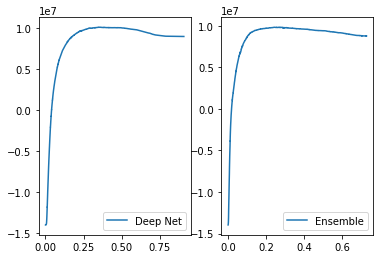

In [75]:
deepnet_max_index = deepnet_cost['cost'].idxmax()
deepnet_max_gain = deepnet_cost.loc[deepnet_max_index]['cost']
deepnet_max_threshold = deepnet_cost.loc[deepnet_max_index]['1 probability']

ensemble_max_index = ensemble_cost['cost'].idxmax()
ensemble_max_gain = ensemble_cost.loc[ensemble_max_index]['cost']
ensemble_max_threshold = ensemble_cost.loc[ensemble_max_index]['1 probability']

print(f'Deepnet: Le gain maximum est {deepnet_max_gain} et il est obtenu avec un seuil de {deepnet_max_threshold}')
print(f'Ensemble: Le gain maximum est {ensemble_max_gain} et il est obtenu avec un seuil de {ensemble_max_threshold}')

plt.subplot(1,2,1)
plt.plot(deepnet_cost['1 probability'],deepnet_cost['cost'].values, label='Deep Net')
plt.legend()
plt.subplot(1,2,2)
plt.plot(ensemble_cost['1 probability'],ensemble_cost['cost'].values, label='Ensemble')
plt.legend()
plt.show()